In [98]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import matplotlib.dates as mdates
from prophet.plot import add_changepoints_to_plot
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("data.csv",low_memory=False)

In [3]:
df.head(3)

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,AMP #,Vendor Name,UMIS BILL ID,Revenue Month,Service Start Date,Service End Date,# days,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,1842037,2010-01,12/24/2009,01/26/2010,33.0,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,1844205,2010-02,01/26/2010,02/25/2010,30.0,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,1841378,2010-03,02/25/2010,03/26/2010,29.0,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43


In [4]:
df = df.sort_values('Revenue Month')

In [5]:
df['Revenue Month'] = pd.to_datetime(df['Revenue Month'])

### The dataset is a monthly data and not daily data and hence we will move ahead with just monthly and yearly aggergated predictions and analysis

In [6]:
dfm = df[['Borough','Consumption (KWH)','Revenue Month']]

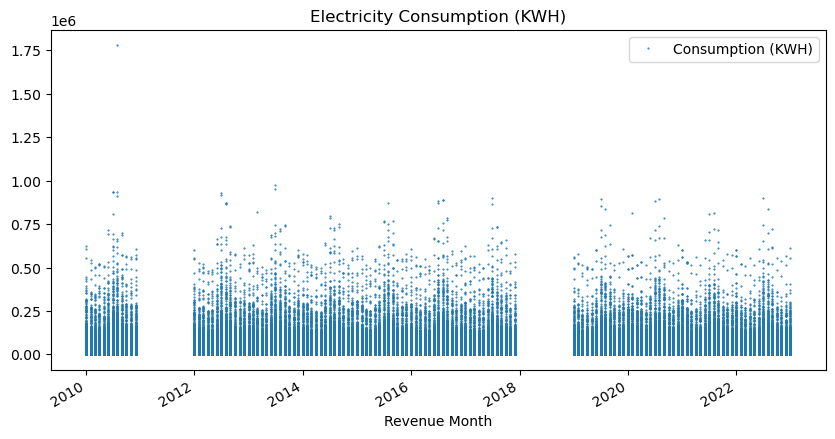

In [7]:
color_pal = sns.color_palette()
dfm.plot(style='.',
         x = 'Revenue Month',
         y='Consumption (KWH)',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Electricity Consumption (KWH)')
plt.show()

### There are a few outliers as per the plot but we can avoid them as they are few and might be due to special cases such as holidays or other events and the model might learn some pattern here. Also, clearly we can see periodic spikes 

In [8]:
def plot_borough(df):
    boroughs = df['Borough'].unique()
    for borough in boroughs:
        borough_df = df[df['Borough'] == borough]
        plt.plot(borough_df['Revenue Month'], borough_df['Consumption (KWH)'], label=borough)
        plt.xlabel('Revenue Month')
        plt.ylabel('Consumption (KWH)')
        plt.title(f'{borough} plot')
        plt.legend()
        plt.show()

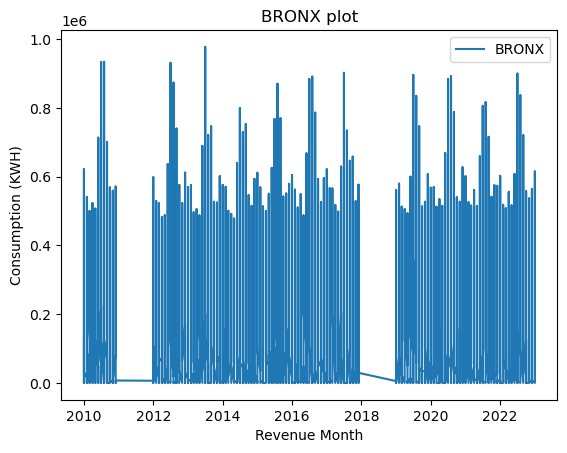

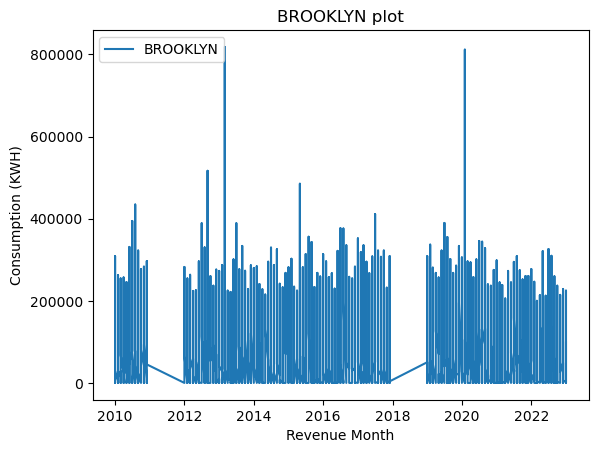

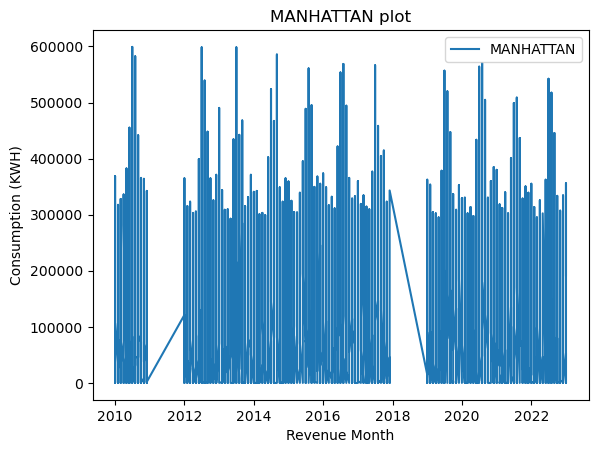

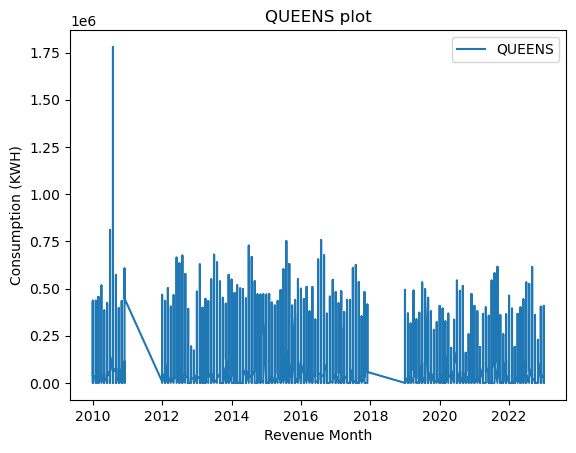

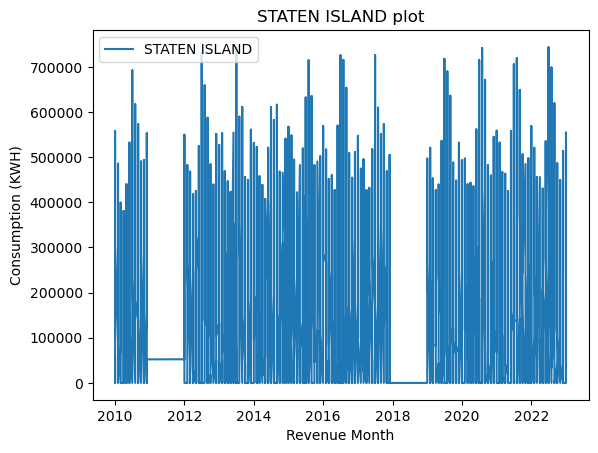

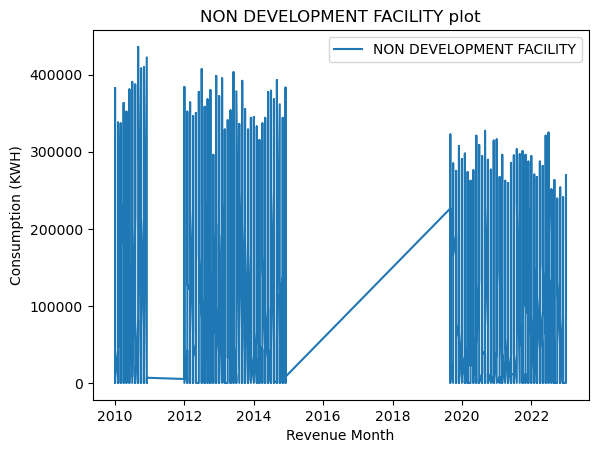

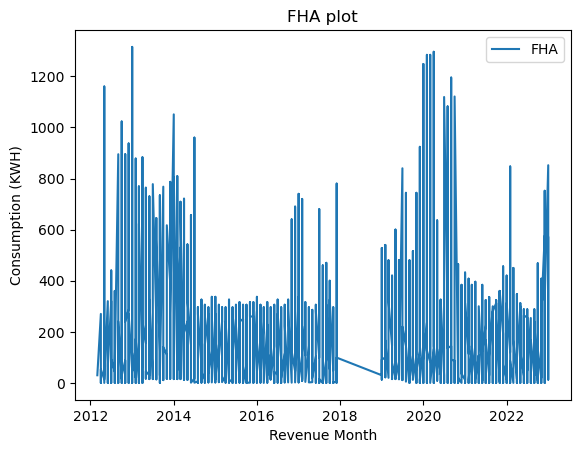

In [9]:
plot_borough(dfm)

### The distribution of the consumption across all the Boroughs show a pattern and we shall analyse this further ahead.

### There are missing values for some durations in the above graphs. However interpolation of time series data can add bias in the model and lead it to learn biased patterns. Hence we shall avoid interpolation.

In [13]:
x = dfm
x['Month'] = dfm['Revenue Month'].dt.month

C:\Users\yashk\AppData\Local\Temp\ipykernel_23168\305753379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Month'] = dfm['Revenue Month'].dt.month


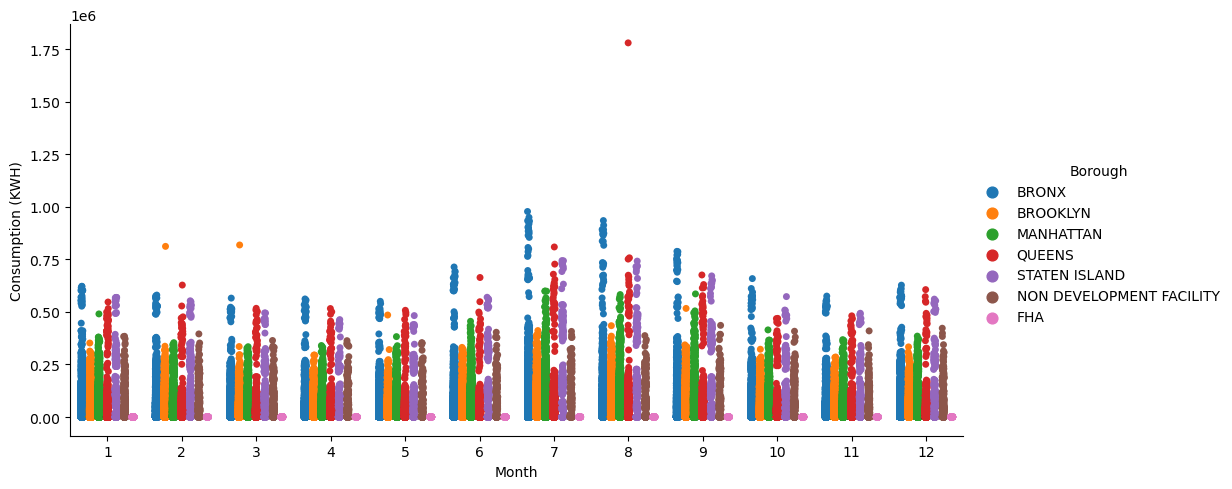

In [14]:
sns.catplot(data=x.dropna(),
            x='Month',
            y='Consumption (KWH)',
           hue = 'Borough',
            dodge=True,
            height=5, aspect=2
           )
plt.show()

## Consumption over the months segregated by Boroughs show that the consumption is highest by BRONX, followed by Queens, Staten Island, Manhattan and the least consumption is by Brooklyn

### Population Stats of the 5 Boroughs

| Borough | Population |
| --- | --- |
| Brooklyn | 22,85,223 |
| Bronx | 12,25,092 |
| Manhattan | 14,62,015 |
| Queens | 20,88,870 |
| Staten Island | 4,14,402 |


Despite the higher population in Brooklyn the consumption is lower. An intersting fact for further analysis

### Electricty consumption across all Boroughs increases between July and October, probably due to the Summer

## Our data for each month is split into consumption by various locations. We need a single data point for our analysis further for each month. We will take the mean of the values per month and create a new data frame. The mean value would also help to reduce the effect of outliers on our learning.

In [17]:
dfm1= pd.DataFrame()
dfm1['ds'] = dfm['Revenue Month']
dfm1['y'] = dfm[['Consumption (KWH)', 'Revenue Month' ]].groupby('Revenue Month').transform('mean')

In [18]:
dfm1 = dfm1.drop_duplicates(keep='first')

Text(0.5, 1.0, 'Average Monthly Consumtion over the years')

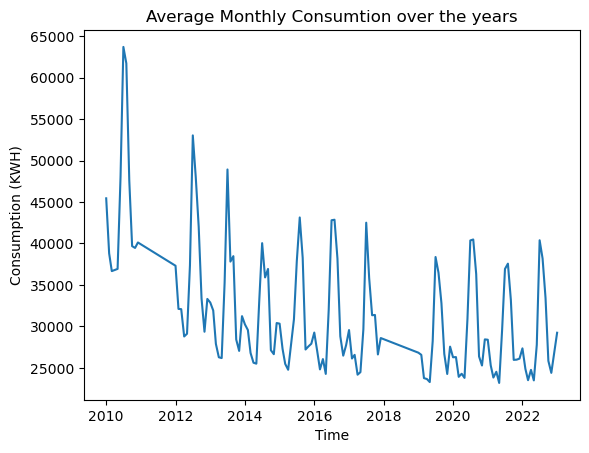

In [20]:
plt.plot( dfm1['ds'], dfm1['y'])
plt.xlabel('Time')
plt.ylabel('Consumption (KWH)')
plt.title('Average Monthly Consumtion over the years')

The overall plot here shows that the consumption has reduced since 2012 and shows a periodic pattern ahead. We are ignoring the missing values for 2011 and 2019 for now.

# Train Test Split

In [21]:
df_train = dfm1.loc[dfm['Revenue Month'].dt.year < 2021 ].copy()
df_test = dfm1.loc[dfm['Revenue Month'].dt.year >= 2021 ].copy()


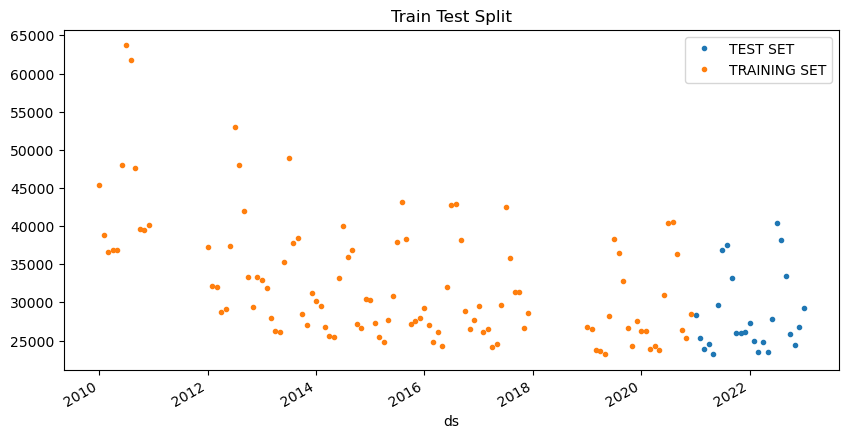

In [22]:
df_test \
    .rename(columns={'y': 'TEST SET'}) \
    .merge(df_train.rename(columns={'y': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Train Test Split', x='ds', style='.')
plt.show()

# Basic FB Prophet Model

In [23]:
df_train

,ds,y
0,2010-01-01,45446.030782
29001,2010-02-01,38808.144583
17143,2010-03-01,36667.210941
5210,2010-04-01,36808.514463
18693,2010-05-01,36933.632880
...,...,...
357381,2020-08-01,40483.057185
320783,2020-09-01,36314.894028
362632,2020-10-01,26375.258216
358949,2020-11-01,25281.385157


In [50]:
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(25, freq='M') #period is in units of days
forecast = m.predict(future)
forecast = model.predict(df_test)
forecast.head(5)

10:57:04 - cmdstanpy - INFO - Chain [1] start processing
10:57:04 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,28548.283571,24844.854711,29874.058724,28547.346748,28548.283571,-1017.626598,-1017.626598,-1017.626598,-1017.626598,-1017.626598,-1017.626598,0.0,0.0,0.0,27530.656973
1,2021-02-01,28516.753271,22390.668913,27641.535163,28510.183959,28521.237609,-3358.054812,-3358.054812,-3358.054812,-3358.054812,-3358.054812,-3358.054812,0.0,0.0,0.0,25158.698459
2,2021-03-01,28488.274291,20522.687917,25617.068159,28471.133230,28501.498379,-5460.629895,-5460.629895,-5460.629895,-5460.629895,-5460.629895,-5460.629895,0.0,0.0,0.0,23027.644396
3,2021-04-01,28456.743991,19653.607884,24760.939338,28426.441020,28481.702778,-6225.568161,-6225.568161,-6225.568161,-6225.568161,-6225.568161,-6225.568161,0.0,0.0,0.0,22231.175830
4,2021-05-01,28426.230798,19563.039788,24730.916557,28382.378396,28465.270047,-6221.609996,-6221.609996,-6221.609996,-6221.609996,-6221.609996,-6221.609996,0.0,0.0,0.0,22204.620802


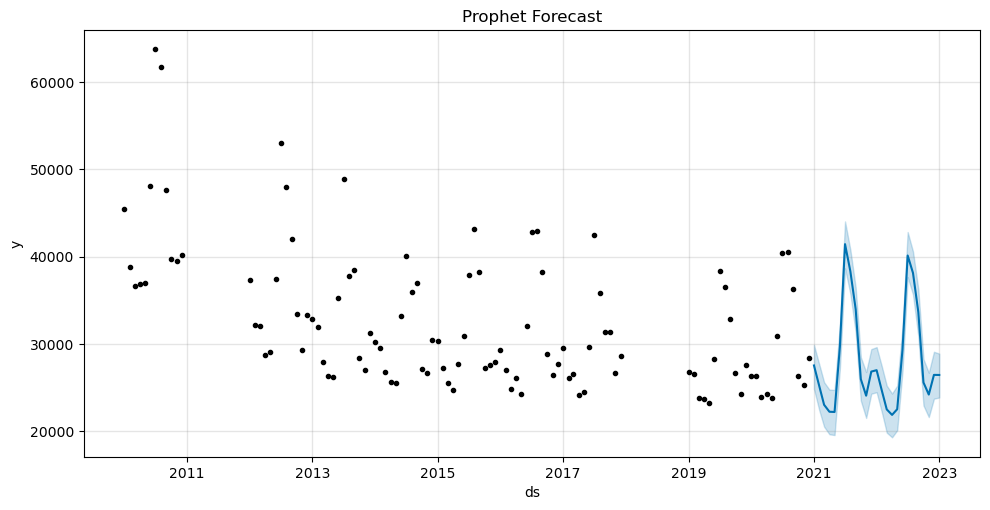

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(forecast, ax=ax,uncertainty=True)
ax.set_title('Prophet Forecast')
plt.show()

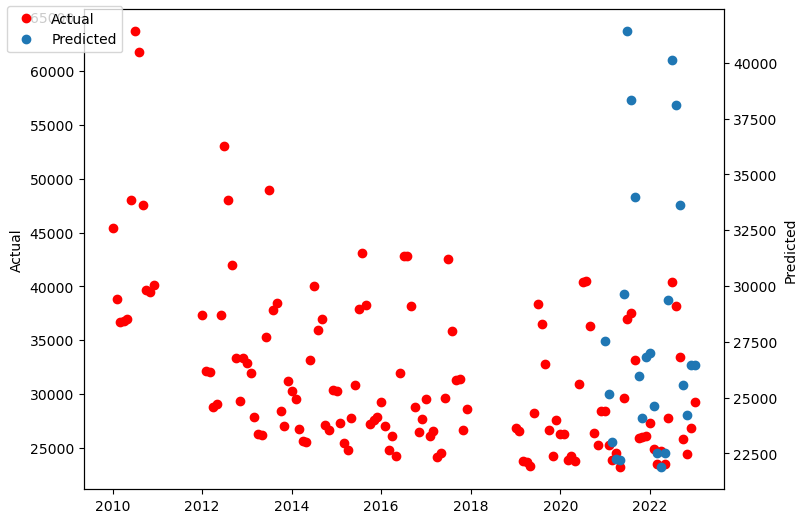

In [52]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(dfm1['ds'],dfm1['y'], 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(forecast['ds'], forecast['yhat'],'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.show()

## The model is has performed well but it also predicted some outliers learnt from the data  before 2012

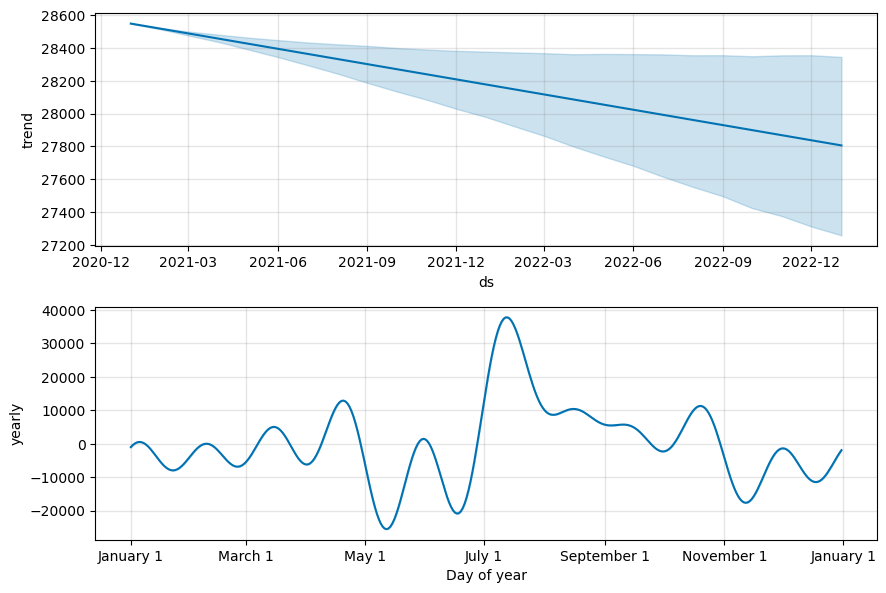

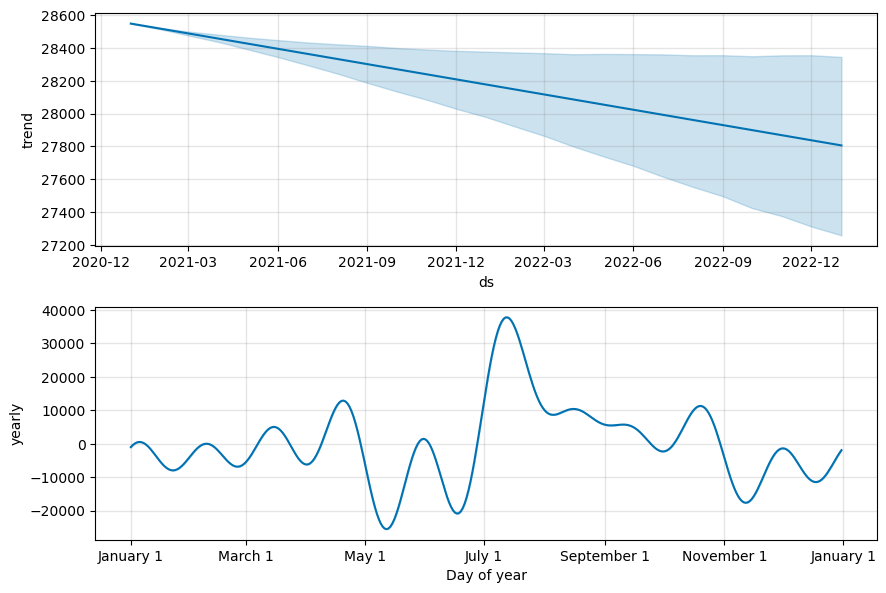

In [33]:
model.plot_components(forecast)

## The components show that the model is able to understand that the trend of consumption is a downward slope but the uncertainity is high as we go ahead in time. Also, it shows that the consumption is usually higher between July and November probably because of the AC usage

In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))

print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  1473.0245544998672
MAE:  999.4754284774866
MAPE:  3.5833165797548596


## Though we have higher error values but the percentage of these errors are lower.

# Tuning the model to various parameters

### Logistic Forecasting growth. Default is linear

11:14:51 - cmdstanpy - INFO - Chain [1] start processing
11:14:51 - cmdstanpy - INFO - Chain [1] done processing


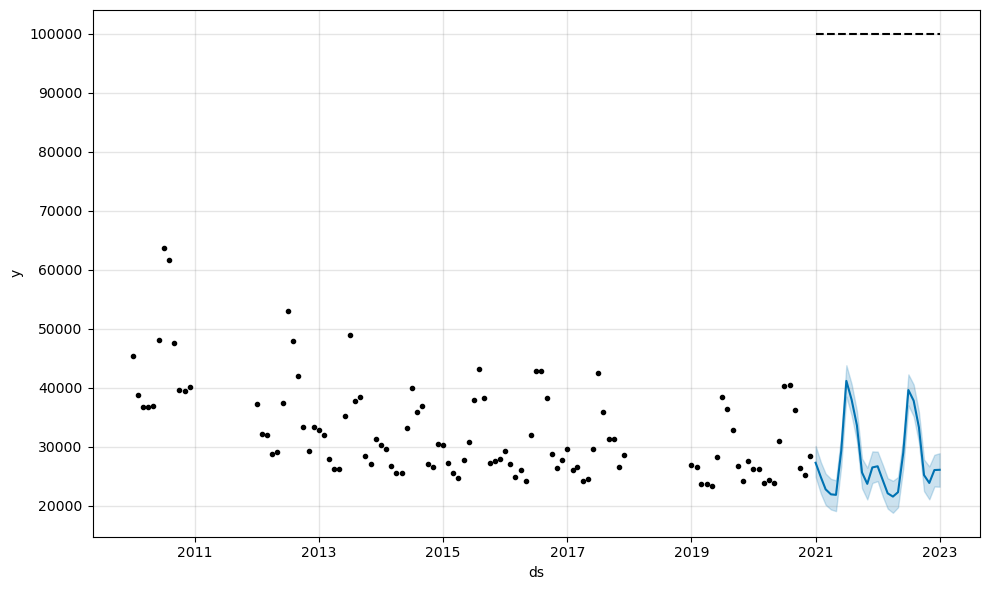

In [83]:
model = Prophet(growth='logistic')
df_train['cap'] = 100000
df_test['cap'] = 100000
model.fit(df_train)
future = model.make_future_dataframe(periods=25, freq = 'M')
future['cap'] = 100000
forecast = model.predict(df_test)
fig = model.plot(forecast)

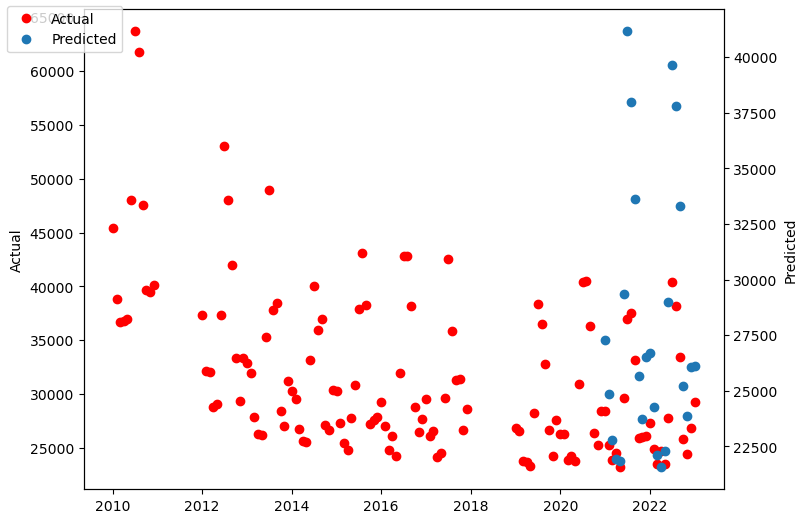

In [84]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(dfm1['ds'],dfm1['y'], 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(forecast['ds'], forecast['yhat'],'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.show()

In [85]:
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))

print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  1582.1993102134672
MAE:  1178.3946482583974
MAPE:  4.289592528583189


## The performance of the matrix has reduced with logistic growth

# With fourier seasonality

In [94]:
m = Prophet()
m.add_seasonality(name="monthly", period=30,fourier_order=2)
m.fit(df_train)
future = m.make_future_dataframe(25, freq='M') #period is in units of months
forecast = m.predict(future)
forecast = model.predict(df_test)
forecast.head(5)

11:19:29 - cmdstanpy - INFO - Chain [1] start processing
11:19:29 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,28312.148736,100000,24555.025627,29928.451944,28312.148736,28312.148736,-1023.678563,-1023.678563,-1023.678563,-1023.678563,-1023.678563,-1023.678563,0.0,0.0,0.0,27288.470173
1,2021-02-01,28276.862795,100000,22288.193584,27525.274145,28276.828816,28276.828816,-3435.023121,-3435.023121,-3435.023121,-3435.023121,-3435.023121,-3435.023121,0.0,0.0,0.0,24841.839674
2,2021-03-01,28245.014531,100000,20052.314523,25439.841207,28242.079648,28247.481805,-5464.033009,-5464.033009,-5464.033009,-5464.033009,-5464.033009,-5464.033009,0.0,0.0,0.0,22780.981522
3,2021-04-01,28209.779336,100000,19064.974691,24367.417034,28201.354791,28217.596710,-6271.939525,-6271.939525,-6271.939525,-6271.939525,-6271.939525,-6271.939525,0.0,0.0,0.0,21937.839811
4,2021-05-01,28175.706178,100000,19308.414848,24580.500674,28160.046411,28190.149412,-6325.743705,-6325.743705,-6325.743705,-6325.743705,-6325.743705,-6325.743705,0.0,0.0,0.0,21849.962473


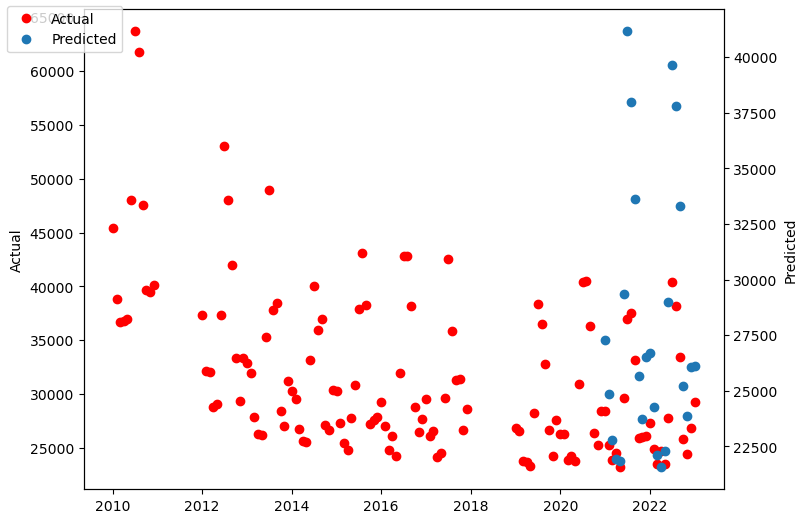

In [95]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(dfm1['ds'],dfm1['y'], 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(forecast['ds'], forecast['yhat'],'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.show()

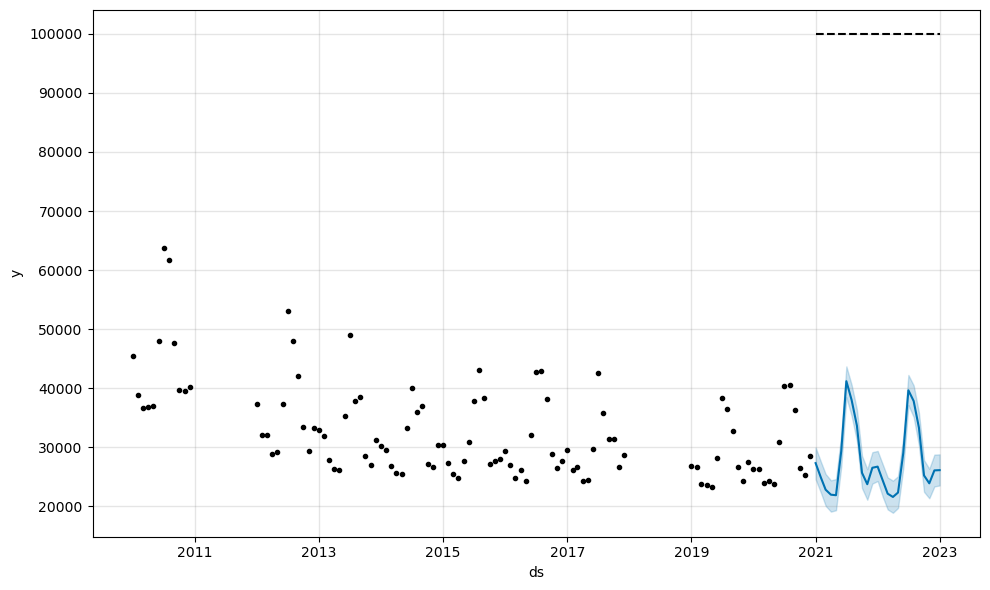

In [96]:
fig = model.plot(forecast)

In [99]:
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))

print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  1582.1993102134672
R2 Error:  0.9017628771102626
MAE:  1178.3946482583974
MAPE:  4.289592528583189


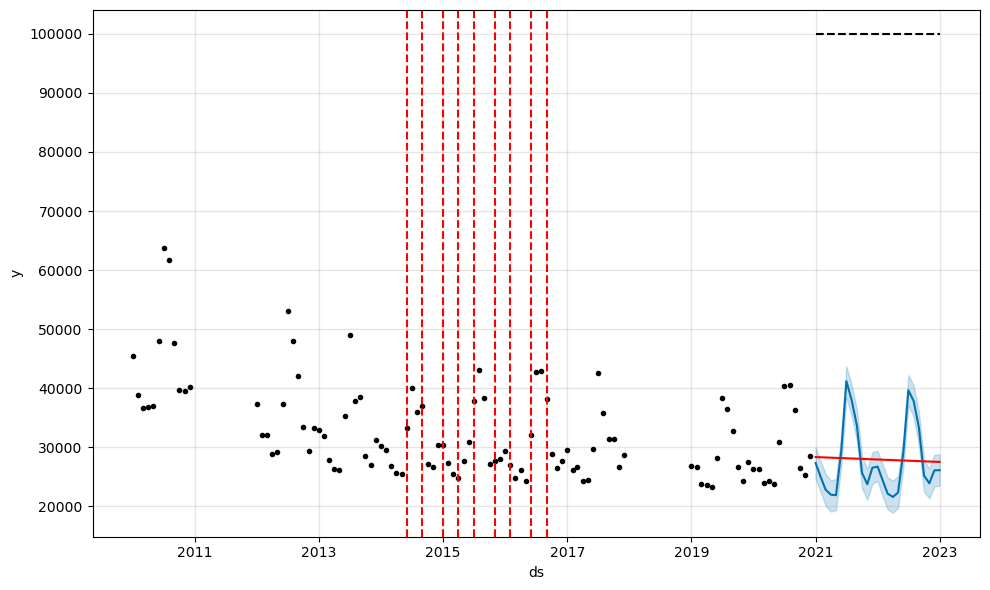

In [100]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

The result has worsend further as the fourier seasonality used does not align with the actual seasonality

# Adding covid lockdown and missing data period as one off holidays to avoid any influence of these data points on the trend

In [127]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'missing_data_1', 'ds': '2012-01-01', 'lower_window': 0, 'ds_upper': '2012-12-31'},
    {'holiday': 'missing_data_2', 'ds': '2018-01-01', 'lower_window': 0, 'ds_upper': '2018-12-31'},

])

for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13
4,missing_data_1,2012-01-01,0,2012-12-31,365
5,missing_data_2,2018-01-01,0,2018-12-31,364


In [128]:
m2 = Prophet(holidays=lockdowns)
m2 = m2.fit(df_train)
future = m2.make_future_dataframe(periods=25, freq='M')
forecast = m2.predict(df_test)

11:32:39 - cmdstanpy - INFO - Chain [1] start processing
11:32:39 - cmdstanpy - INFO - Chain [1] done processing


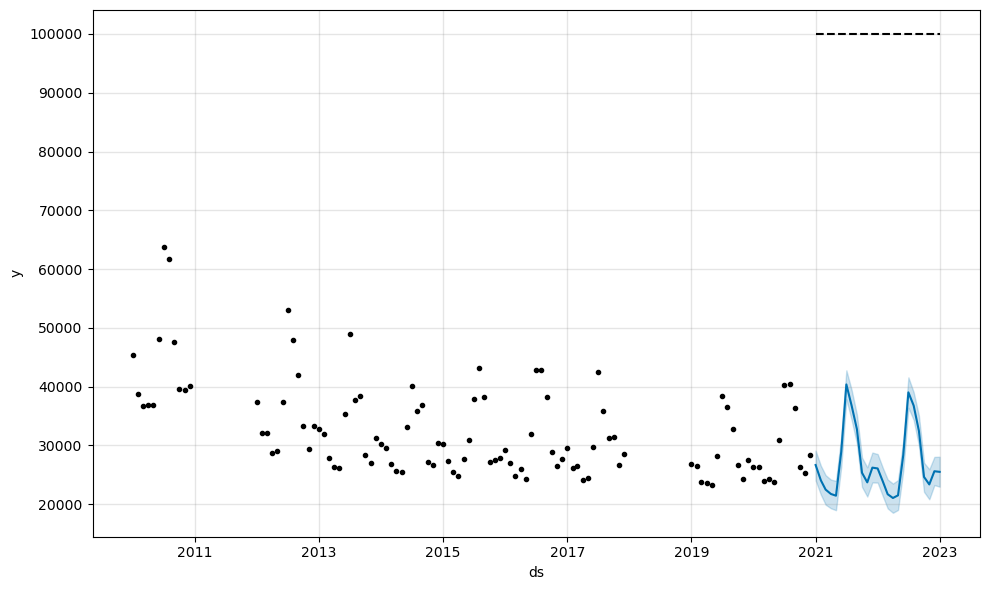

In [129]:
fig = model.plot(forecast)

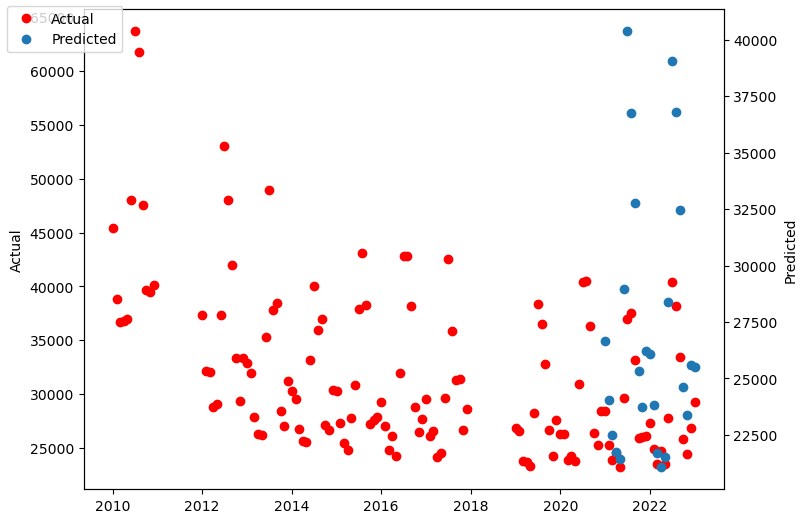

In [130]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(dfm1['ds'],dfm1['y'], 'ro')
a1.set_ylabel('Actual')
a2 = a1.twinx()
a2.plot(forecast['ds'], forecast['yhat'],'o')
a2.set_ylabel('Predicted')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.show()

In [131]:
print("MSE: ", np.sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'])))

print("R2 Error: ", r2_score(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAE: ", mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat']))

print("MAPE: ", mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast['yhat']))

MSE:  1811.378202113939
R2 Error:  0.8712427989488959
MAE:  1534.9533793108474
MAPE:  5.590052585013893


# For future predictions we will be using the linear model with our holiday dataset

Should the unit of time be month, then predict the EC for 1/6/9 months into the future.

11:37:30 - cmdstanpy - INFO - Chain [1] start processing
11:37:30 - cmdstanpy - INFO - Chain [1] done processing


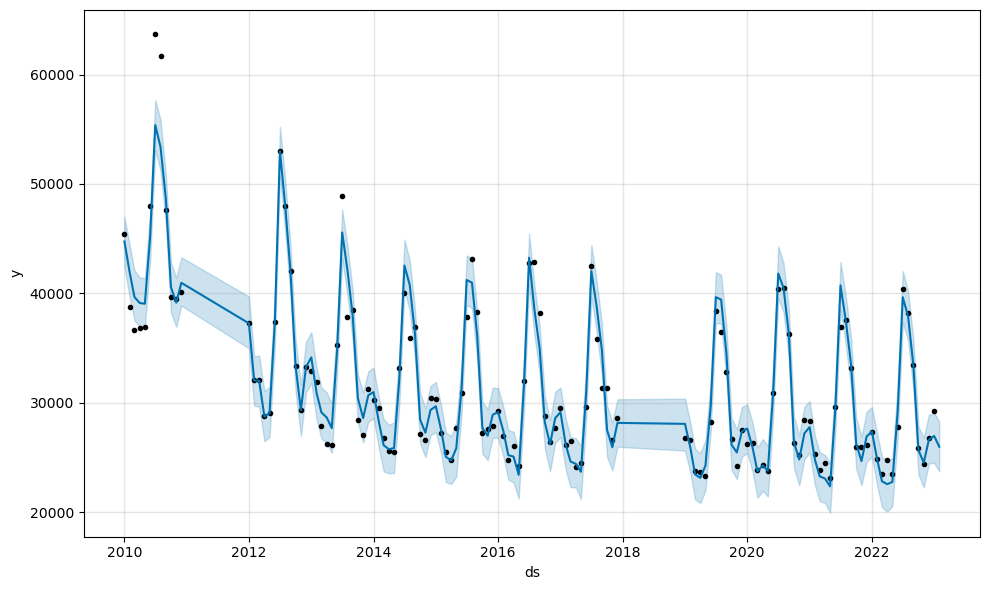

In [137]:
m = Prophet(holidays=lockdowns)
m = m.fit(dfm1)
future = m.make_future_dataframe(periods=1, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

11:37:46 - cmdstanpy - INFO - Chain [1] start processing
11:37:46 - cmdstanpy - INFO - Chain [1] done processing


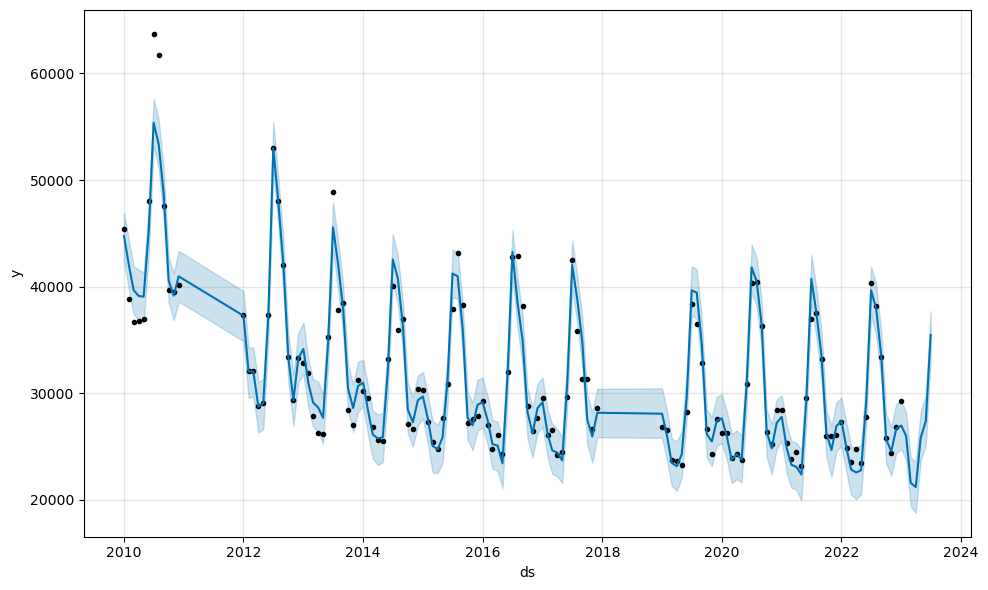

In [138]:
m = Prophet(holidays=lockdowns)
m = m.fit(dfm1)
future = m.make_future_dataframe(periods=6, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

11:37:55 - cmdstanpy - INFO - Chain [1] start processing
11:37:56 - cmdstanpy - INFO - Chain [1] done processing


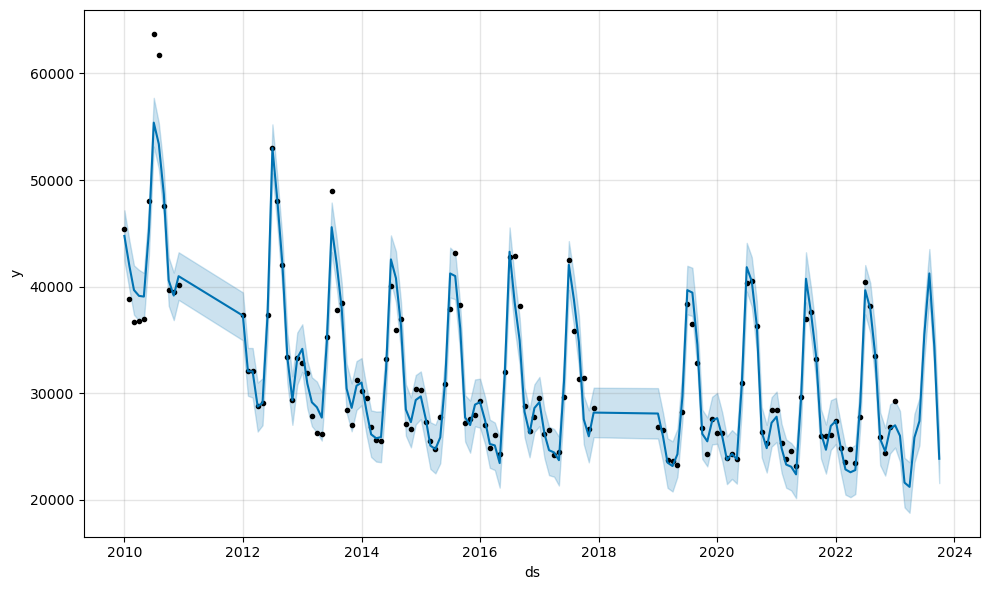

In [139]:
m = Prophet(holidays=lockdowns)
m = m.fit(dfm1)
future = m.make_future_dataframe(periods=9, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

Should the unit of time be year, then predict the EC for 1/10/20 years into the future.

In [207]:
dfy = df[['Consumption (KWH)', 'Revenue Month']]
dfy['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
dfy['Year'] = dfy['Revenue Month'].dt.year
dfy = dfy[['avg_by_year','Year']]
dfy.columns = ['y','ds']
dfy = dfy.drop_duplicates(keep='first').reset_index(drop=True)
dfy['ds'] = pd.to_datetime(dfy['ds'], format='%Y')

C:\Users\yashk\AppData\Local\Temp\ipykernel_23168\3805595031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfy['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
C:\Users\yashk\AppData\Local\Temp\ipykernel_23168\3805595031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfy['Year'] = dfy['Revenue Month'].dt.year


In [208]:
dfy

,y,ds
0,44612.137796,2010-01-01
1,36346.207317,2012-01-01
2,32702.755515,2013-01-01
3,30694.267709,2014-01-01
4,30726.874515,2015-01-01
5,30849.120661,2016-01-01
6,29747.362545,2017-01-01
7,28191.254194,2019-01-01
8,28353.656726,2020-01-01
9,28162.642161,2021-01-01


12:25:53 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing


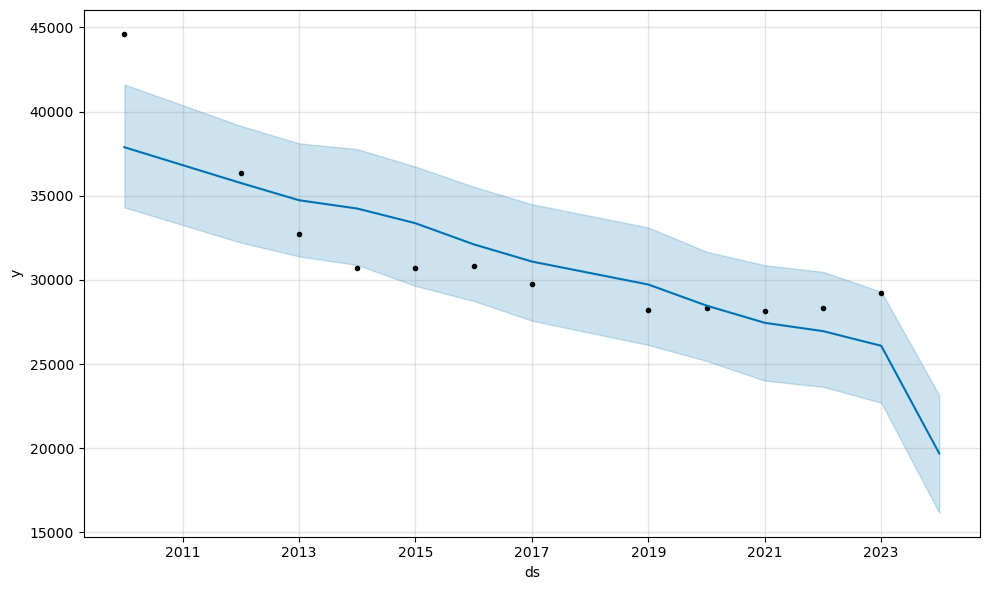

In [209]:
m = Prophet()
m = m.fit(dfy)
future = m.make_future_dataframe(periods=1, freq='Y') #period is in units of Years
forecast = m.predict(future)
m.plot(forecast);

12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing


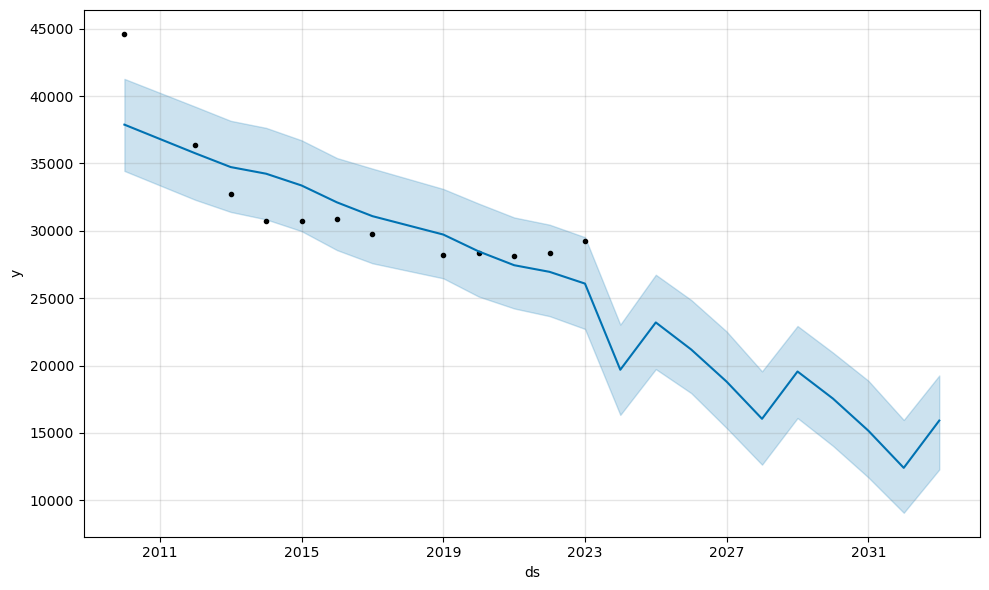

In [210]:
m = Prophet()
m = m.fit(dfy)
future = m.make_future_dataframe(periods=10, freq='Y') #period is in units of Years
forecast = m.predict(future)
m.plot(forecast);

12:25:55 - cmdstanpy - INFO - Chain [1] start processing
12:26:31 - cmdstanpy - INFO - Chain [1] done processing


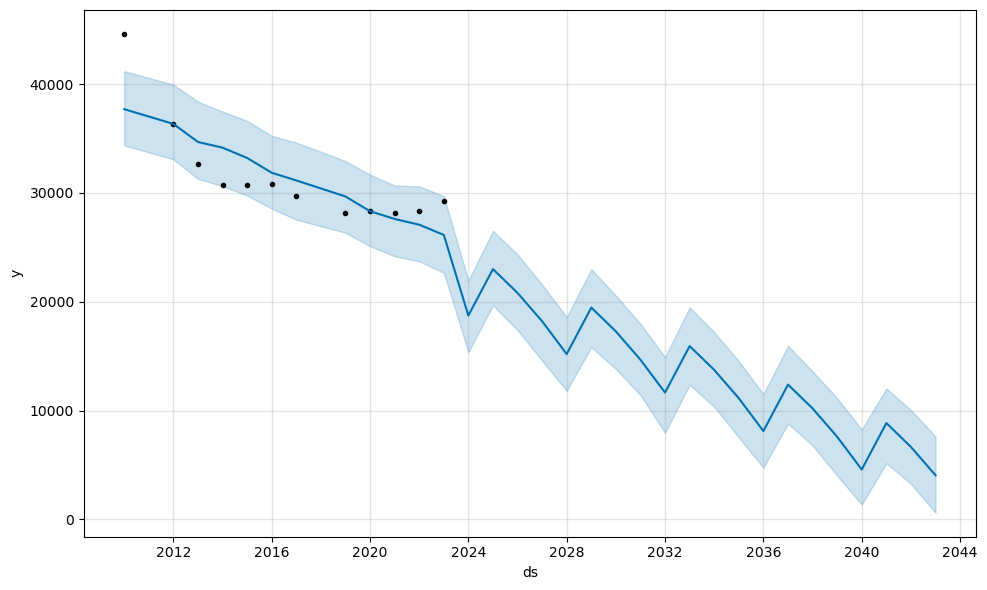

In [211]:
m = Prophet(holidays=lockdowns)
m = m.fit(dfy)
future = m.make_future_dataframe(periods=20, freq='Y') #period is in units of Years
forecast = m.predict(future)
m.plot(forecast);

# Using the mean data by year provides a downward slope and the model is not able to learn any patterns. We shall use the monthly data for the same predictions to show the contrast

12:26:32 - cmdstanpy - INFO - Chain [1] start processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing


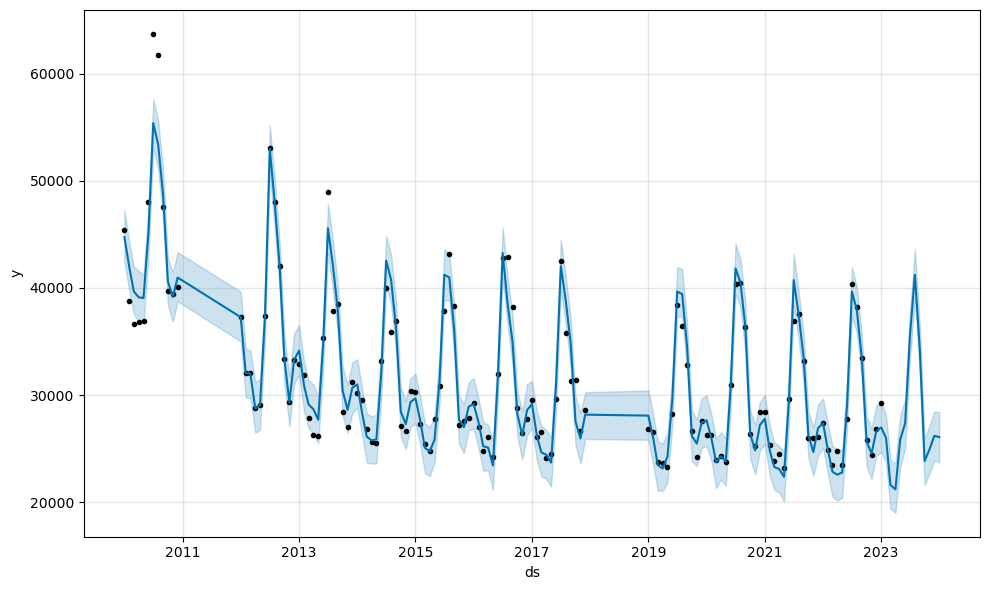

In [212]:
m = Prophet(holidays=lockdowns)
m = m.fit(dfm1)
future = m.make_future_dataframe(periods=12, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

12:26:33 - cmdstanpy - INFO - Chain [1] start processing
12:26:33 - cmdstanpy - INFO - Chain [1] done processing


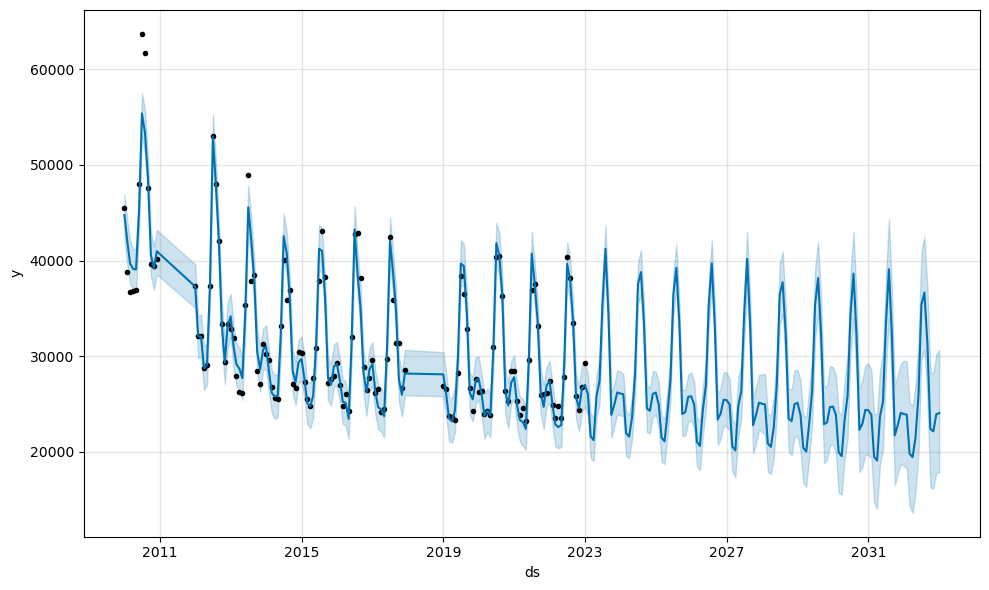

In [213]:
m = Prophet(holidays=lockdowns)
m = m.fit(dfm1)
future = m.make_future_dataframe(periods=12*10, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

12:26:34 - cmdstanpy - INFO - Chain [1] start processing
12:26:34 - cmdstanpy - INFO - Chain [1] done processing


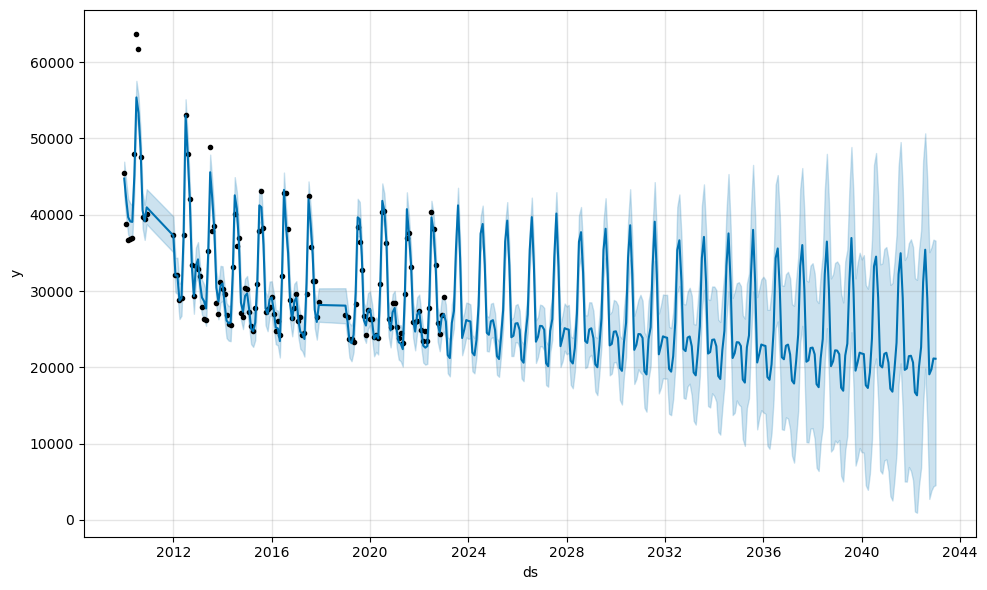

In [214]:
m = Prophet(holidays=lockdowns)
m = m.fit(dfm1)
future = m.make_future_dataframe(periods=12*20, freq='M') #period is in units of Months
forecast = m.predict(future)
m.plot(forecast);

# The future predictions look much better now with monthly mean data. Also the holiday parameter has helped to avoid covid and missing data trends in the future prediction

# Future Prediction for 3 years for 5 Boroughs

In [167]:
dfb = pd.DataFrame()
dfb['y'] = df[['Borough','Revenue Month','Consumption (KWH)']].groupby(['Borough','Revenue Month']).transform('mean')
dfb['ds'] = df['Revenue Month']
dfb['Borough'] = df['Borough']

In [168]:
dfb = dfb.reset_index(drop=True)

In [169]:
dfb

,y,ds,Borough
0,50028.041121,2010-01-01,BRONX
1,37531.571903,2010-01-01,BROOKLYN
2,37531.571903,2010-01-01,BROOKLYN
3,37531.571903,2010-01-01,BROOKLYN
4,37531.571903,2010-01-01,BROOKLYN
...,...,...,...
447844,34826.816393,2023-01-01,BRONX
447845,34826.816393,2023-01-01,BRONX
447846,34826.816393,2023-01-01,BRONX
447847,22148.070295,2023-01-01,BROOKLYN


12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:00 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing


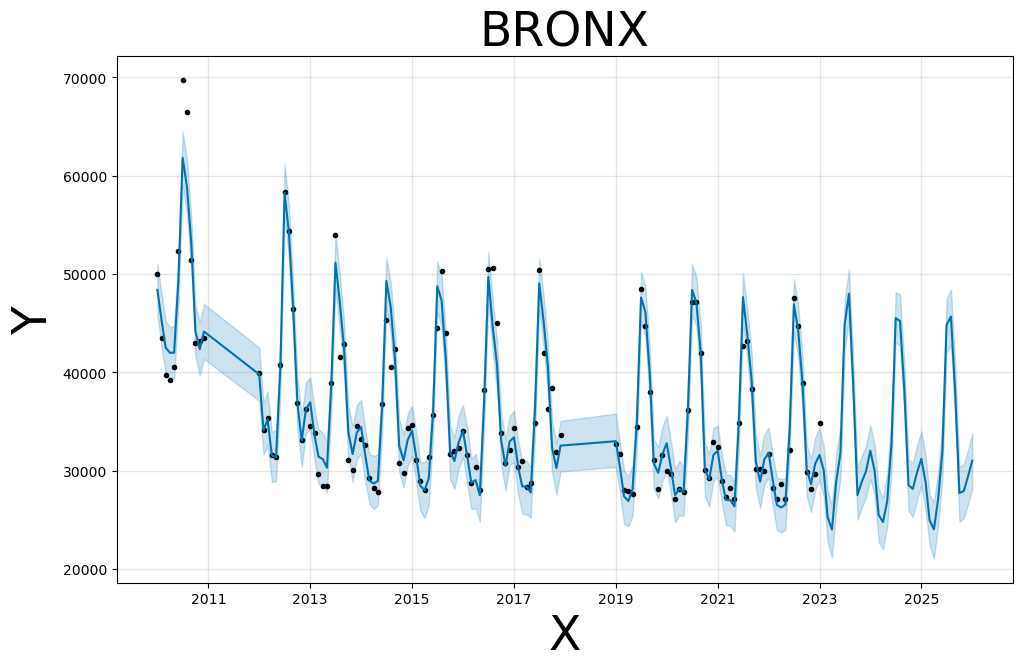

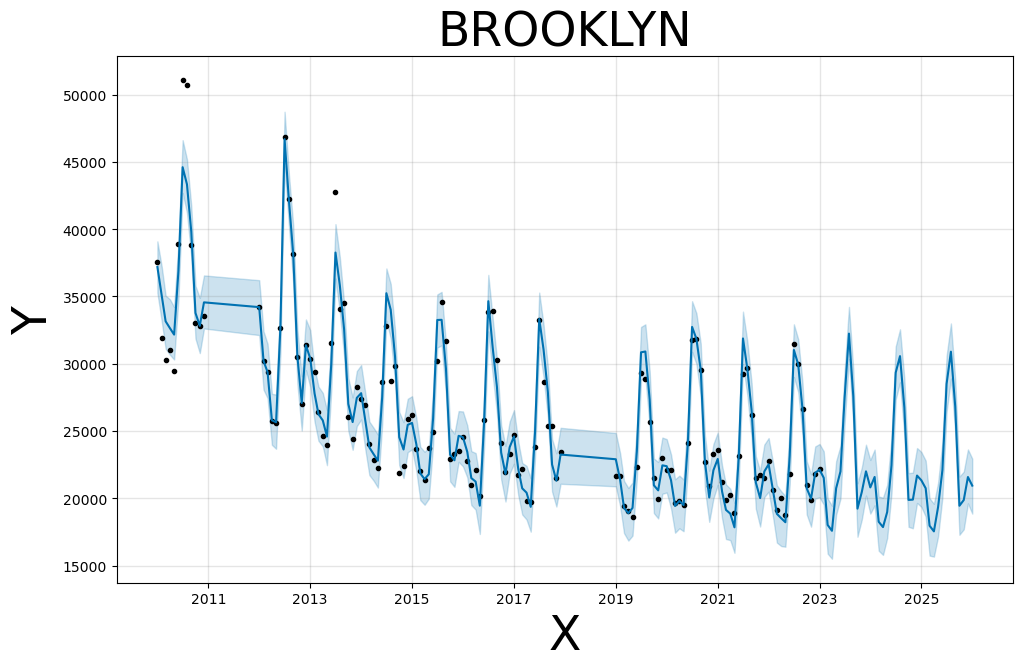

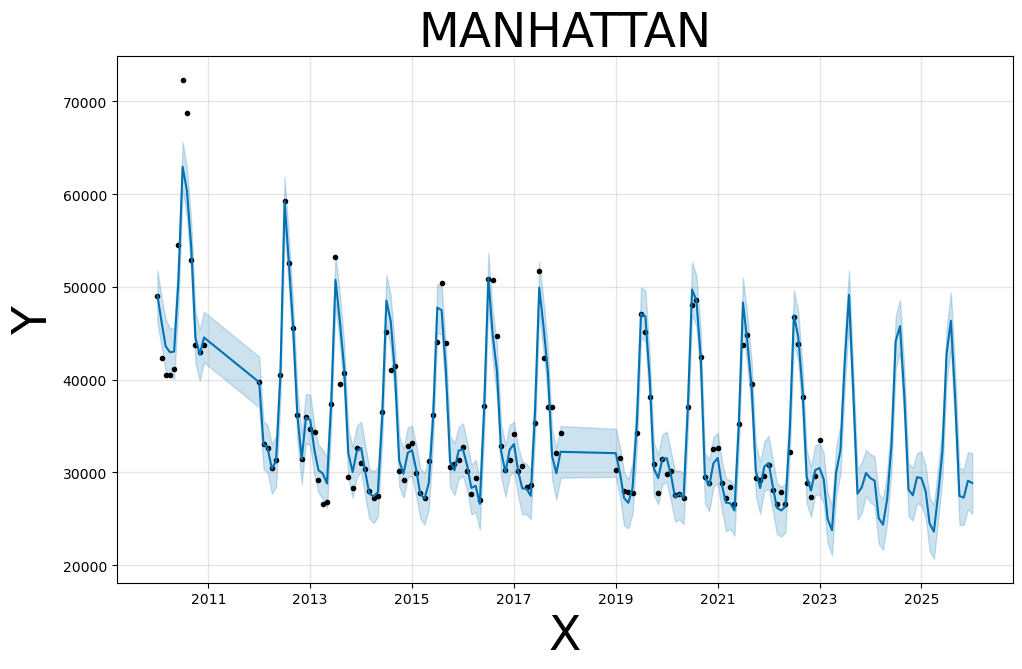

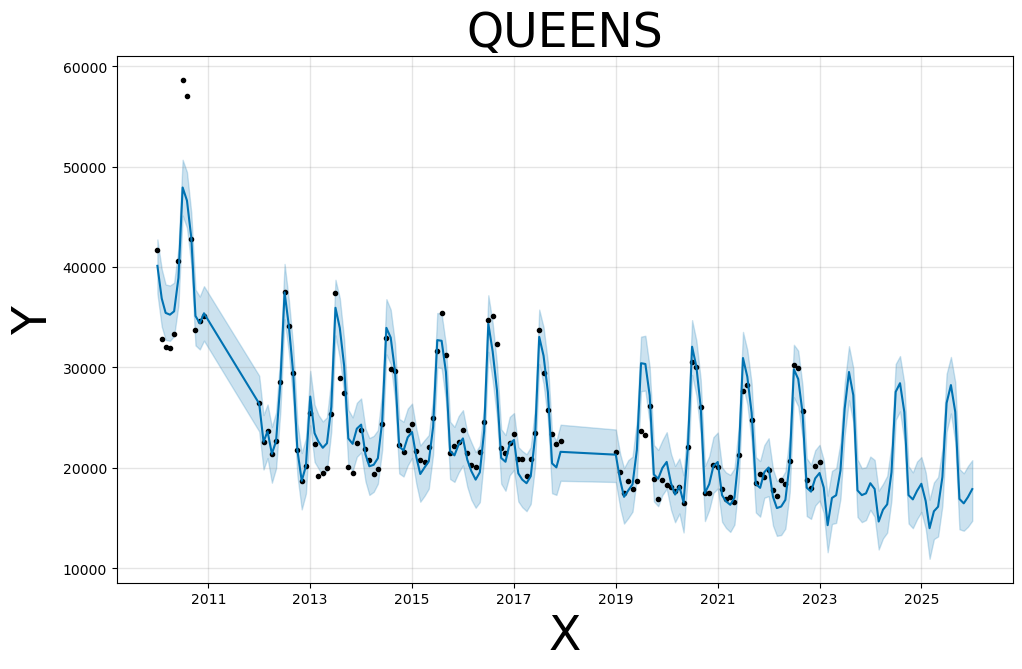

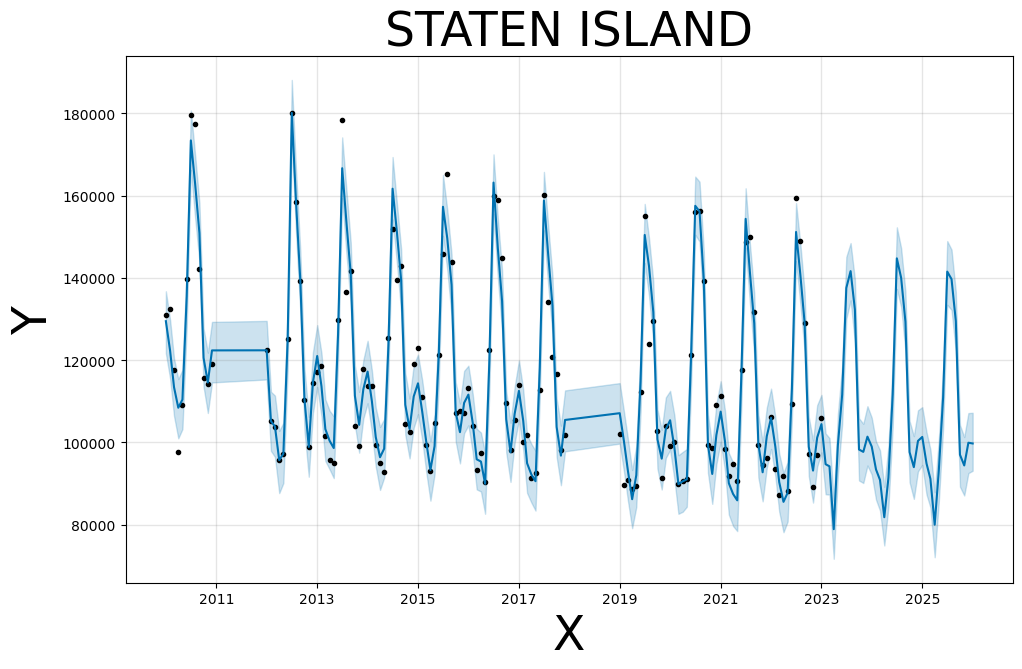

In [206]:
for borough in ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']:
    x = dfb[dfb['Borough']==borough][['y','ds']].drop_duplicates(keep='first')
    m = Prophet(holidays=lockdowns)
    m = m.fit(x)
    future = m.make_future_dataframe(periods=12*3, freq='M') #period is in units of Months
    forecast = m.predict(future)
    fig = m.plot(forecast);
    ax = fig.gca()
    ax.set_title(borough, size=34)
    ax.set_xlabel("X", size=34)
    ax.set_ylabel("Y", size=34)